[*********************100%***********************]  1 of 1 completed

First few daily returns (%):


,TSLA
Date,
2023-12-12,-1.138738
2023-12-13,0.961984
2023-12-14,4.914543
2023-12-15,0.975900
2023-12-18,-0.560157


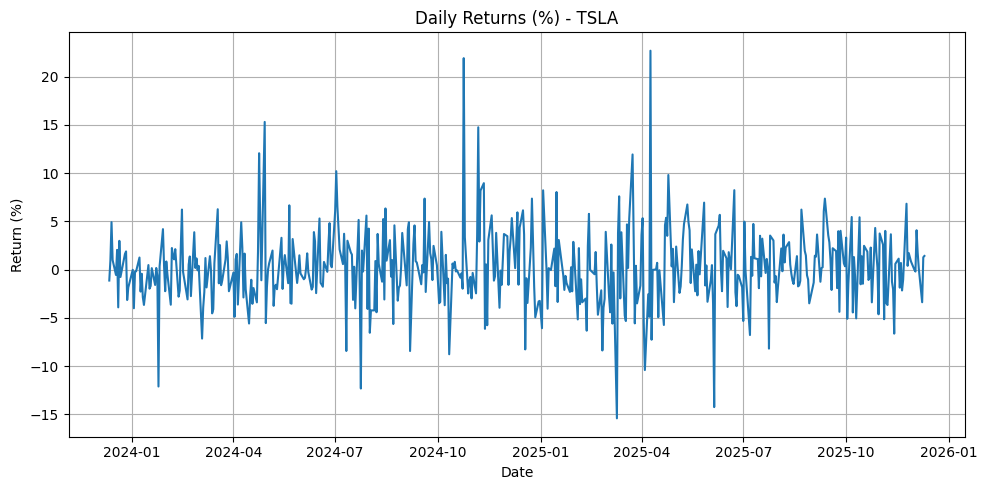


=== Fitting GARCH(1,1) ===
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1397.19
Distribution:                  Normal   AIC:                           2802.38
Method:            Maximum Likelihood   BIC:                           2819.25
                                        No. Observations:                  501
Date:                Wed, Dec 10 2025   Df Residuals:                      500
Time:                        21:15:19   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1931      0.184      1.05

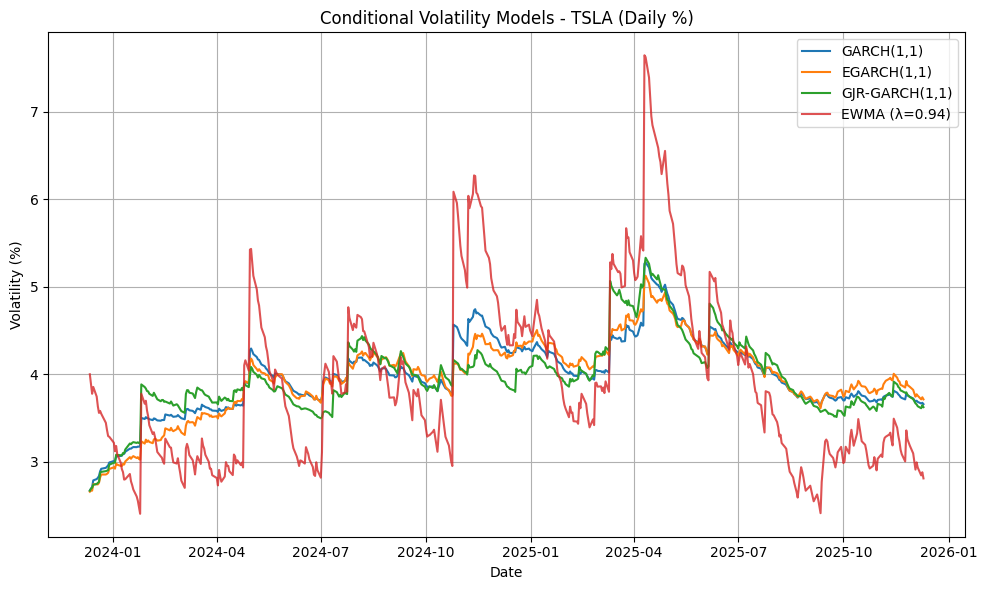


=== VaR & ES Summary by Method ===

---- Alpha = 95% ----
Historical VaR / ES  : VaR = 5.550%, ES = 7.984%  (q = -5.550%)
Normal VaR / ES      : VaR = 6.371%, ES = 8.042%  (q = -6.371%)
GARCH (last day)     : VaR = 5.829%, ES = 7.274%  (q_T = -5.829%)

---- Alpha = 99% ----
Historical VaR / ES  : VaR = 8.783%, ES = 12.225%  (q = -8.783%)
Normal VaR / ES      : VaR = 9.096%, ES = 10.450%  (q = -9.096%)
GARCH (last day)     : VaR = 8.315%, ES = 9.458%  (q_T = -8.315%)

=== Backtesting for 95% VaR (last 250 days) ===

[GARCH]
Observations (N):        250
Exceptions (count):      8
Exception rate:          3.200%
Theoretical rate (1-α):  5.000%
Kupiec LR statistic:     1.9441
Kupiec p-value:          0.1632

[Historical]
Observations (N):        250
Exceptions (count):      14
Exception rate:          5.600%
Theoretical rate (1-α):  5.000%
Kupiec LR statistic:     0.1827
Kupiec p-value:          0.6691

[Normal]
Observations (N):        250
Exceptions (count):      9
Exception rate:      

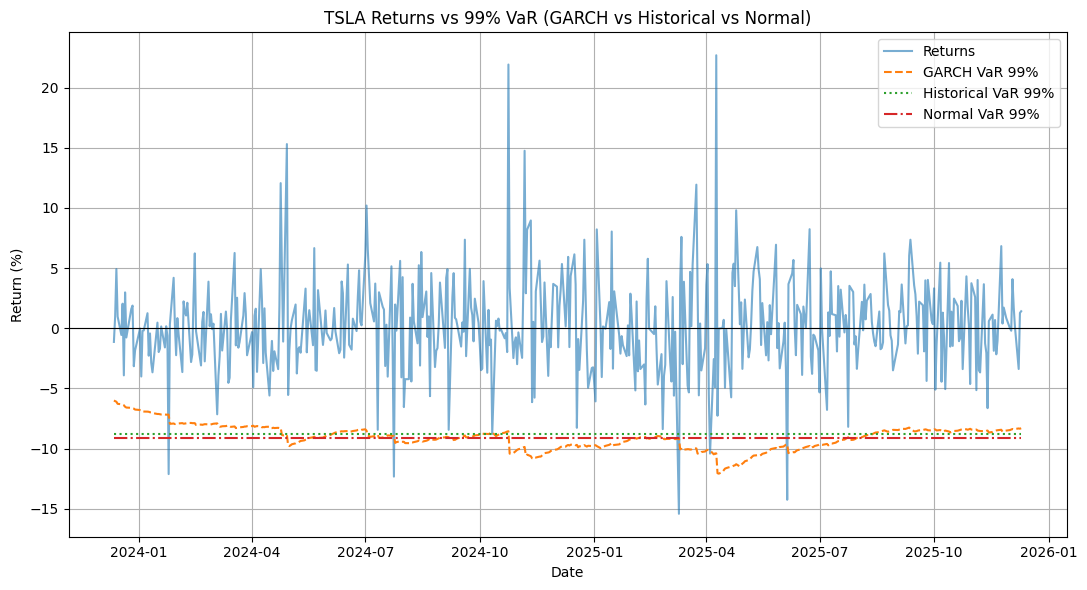

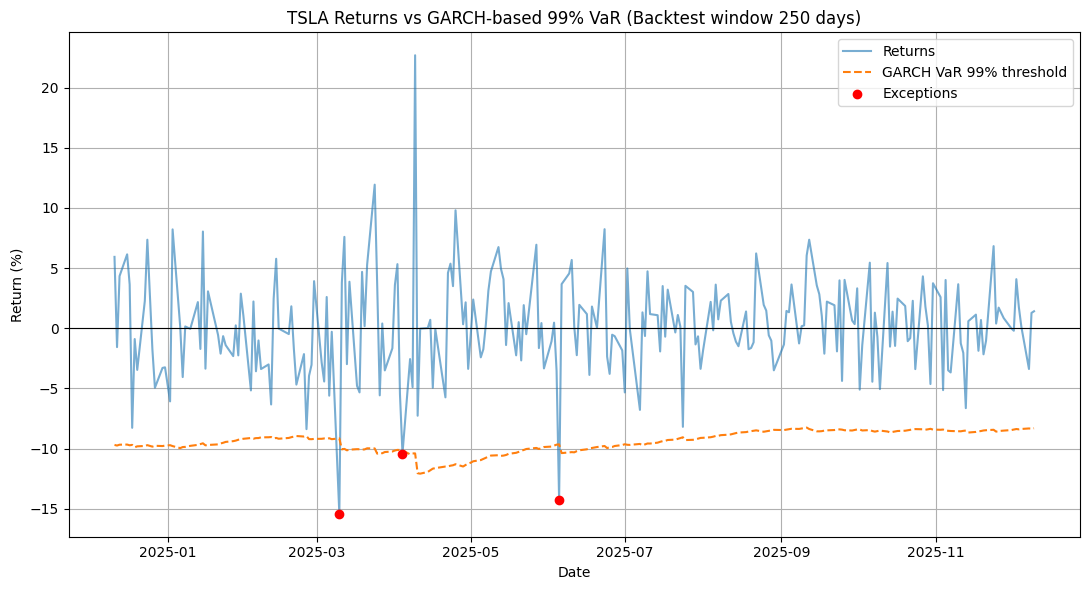

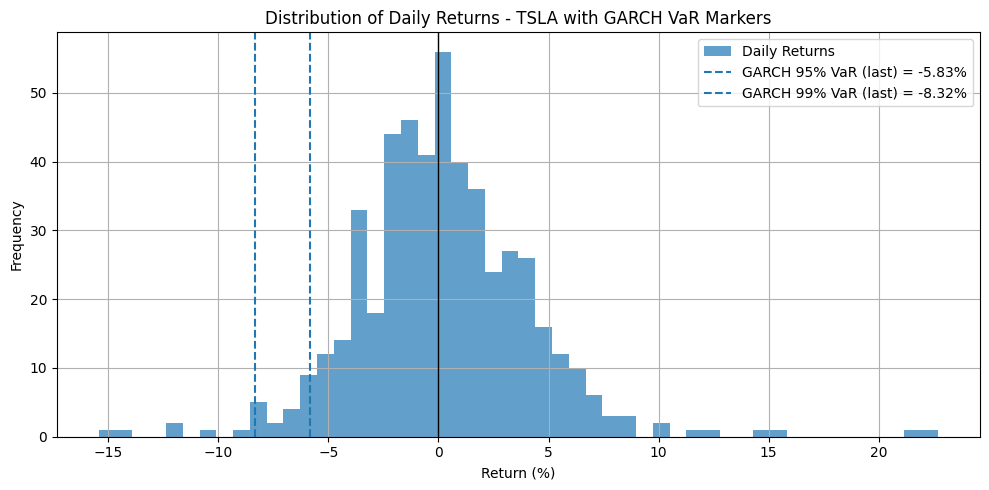

In [15]:
# ============================================================
# Volatility & VaR Risk Lab
# - GARCH / EGARCH / GJR-GARCH / EWMA
# - Historical, Normal, and GARCH-based VaR & ES
# - VaR Backtesting (exceptions, Kupiec, Basel traffic light)
# For TSLA daily returns (2 years)
# ============================================================

!pip install yfinance arch scipy --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import chi2, norm

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# ------------------------------------------------------------
# 1. Load returns (TSLA, last 2 years)
# ------------------------------------------------------------
ticker = "TSLA"

df = yf.download(ticker, period="2y", auto_adjust=False)

# Extract Close as a 1D float Series
close = df["Close"]
if isinstance(close, pd.DataFrame):   # just in case
    close = close.iloc[:, 0]
close = close.astype(float)

# Daily returns in %
returns = close.pct_change().dropna() * 100.0   # percent returns for ARCH/GARCH

print("First few daily returns (%):")
display(returns.head())

plt.figure()
plt.plot(returns.index, returns.values)
plt.title(f"Daily Returns (%) - {ticker}")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 2. Fit volatility models: GARCH(1,1), EGARCH(1,1), GJR-GARCH(1,1)
# ------------------------------------------------------------

print("\n=== Fitting GARCH(1,1) ===")
garch_model = arch_model(returns, mean="Constant", vol="GARCH", p=1, q=1)
garch_res = garch_model.fit(disp="off")
print(garch_res.summary())

print("\n=== Fitting EGARCH(1,1) ===")
egarch_model = arch_model(returns, mean="Constant", vol="EGARCH", p=1, q=1)
egarch_res = egarch_model.fit(disp="off")
print(egarch_res.summary())

print("\n=== Fitting GJR-GARCH(1,1) ===")
gjr_model = arch_model(returns, mean="Constant", vol="GARCH", p=1, o=1, q=1, power=2.0)
gjr_res = gjr_model.fit(disp="off")
print(gjr_res.summary())

# Conditional volatilities (in %)
garch_cond_vol = (
    garch_res.conditional_volatility
    .astype(float)
    .ffill()
    .bfill()
)
egarch_cond_vol = (
    egarch_res.conditional_volatility
    .astype(float)
    .ffill()
    .bfill()
)
gjr_cond_vol = (
    gjr_res.conditional_volatility
    .astype(float)
    .ffill()
    .bfill()
)


# ------------------------------------------------------------
# 3. EWMA volatility (RiskMetrics style)
# ------------------------------------------------------------
def ewma_volatility(returns, lambda_=0.94):
    """
    EWMA volatility (in %) returned as a Pandas Series
    with the same index as 'returns'.
    """
    r = returns.astype(float) / 100.0  # decimal returns
    n = len(r)

    ewma_var = np.zeros(n)
    ewma_var[0] = r.var()  # scalar float

    for t in range(1, n):
        ewma_var[t] = (
            lambda_ * ewma_var[t - 1]
            + (1 - lambda_) * (r.iloc[t - 1] ** 2)
        )

    ewma_vol = pd.Series(np.sqrt(ewma_var) * 100.0, index=r.index)
    return ewma_vol

ewma_vol = ewma_volatility(returns, lambda_=0.94)

print("\nLatest EWMA volatility estimate (%):", float(ewma_vol.iloc[-1]))


# ------------------------------------------------------------
# 4. Volatility Comparison Dashboard
# ------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(garch_cond_vol.index, garch_cond_vol, label="GARCH(1,1)")
plt.plot(egarch_cond_vol.index, egarch_cond_vol, label="EGARCH(1,1)")
plt.plot(gjr_cond_vol.index, gjr_cond_vol, label="GJR-GARCH(1,1)")
plt.plot(ewma_vol.index, ewma_vol, label="EWMA (λ=0.94)", alpha=0.8)
plt.title(f"Conditional Volatility Models - {ticker} (Daily %)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 5. VaR & ES helper functions (Historical, Normal)
# ------------------------------------------------------------
def var_es_historical(returns, alpha=0.99):
    """
    Historical VaR & ES for 1D returns (%).
    Returns: (threshold_q, VaR, ES), all in % (VaR & ES positive loss).
    """
    r = np.asarray(returns.dropna())
    q = np.percentile(r, (1 - alpha) * 100)   # left tail
    var = -q
    tail = r[r <= q]
    es = -tail.mean() if tail.size > 0 else var
    return q, var, es


def var_es_normal(returns, alpha=0.99):
    """
    Parametric Normal VaR & ES for returns (%).
    Uses N(mu, sigma^2) fitted to historical returns.
    Returns: (threshold_q, VaR, ES).
    """
    r = returns.dropna().astype(float)
    mu = r.mean()
    sigma = r.std(ddof=1)
    z = norm.ppf(1 - alpha)  # negative
    z_pos = -z               # positive (e.g. 2.33 for 99%)

    q = mu + sigma * z       # left-tail quantile
    var = -q

    # ES under normal: E[R | R <= q] = mu - sigma * φ(z_pos)/(1-alpha)
    phi_z = norm.pdf(z)
    cond_mean = mu - sigma * phi_z / (1 - alpha)
    es = -cond_mean

    return q, var, es


# ------------------------------------------------------------
# 6. GARCH-based VaR (95% & 99%) + ES (last day)
# ------------------------------------------------------------
returns = returns.astype(float)
mu_hat = float(returns.mean())       # constant mean
sigma_t = garch_cond_vol             # time-varying vol (%)

# we’ll use standard pos z for readability
z_pos_values = {0.95: 1.65, 0.99: 2.33}

# store GARCH VaR series (time-varying)
garch_var_series = {}

print("\n=== VaR & ES Summary by Method ===")
for alpha in sorted(z_pos_values.keys()):
    print(f"\n---- Alpha = {int(alpha*100)}% ----")
    z_pos = z_pos_values[alpha]
    z = -z_pos

    # ---------- Historical ----------
    q_hist, var_hist, es_hist = var_es_historical(returns, alpha=alpha)

    # ---------- Normal ----------
    q_norm, var_norm, es_norm = var_es_normal(returns, alpha=alpha)

    # ---------- GARCH (time-varying) ----------
    # threshold series: q_t = mu - z_pos * sigma_t (since z_pos > 0)
    q_garch_t = mu_hat - z_pos * sigma_t
    q_garch_t = q_garch_t.astype(float)

    # VaR_t as positive magnitude
    var_garch_t = (-q_garch_t).astype(float)
    garch_var_series[alpha] = (q_garch_t, var_garch_t)

    # ES for the *last day* under normal assumption with sigma_T
    sigma_last = float(sigma_t.iloc[-1])
    phi_z = norm.pdf(z)  # = norm.pdf(-z_pos) = norm.pdf(z_pos)
    cond_mean_last = mu_hat - sigma_last * phi_z / (1 - alpha)
    es_garch_last = -cond_mean_last

    # ---------- Print summary ----------
    print("Historical VaR / ES  : "
          f"VaR = {var_hist:.3f}%, ES = {es_hist:.3f}%  (q = {q_hist:.3f}%)")
    print("Normal VaR / ES      : "
          f"VaR = {var_norm:.3f}%, ES = {es_norm:.3f}%  (q = {q_norm:.3f}%)")
    print("GARCH (last day)     : "
          f"VaR = {var_garch_t.iloc[-1]:.3f}%, ES = {es_garch_last:.3f}%  "
          f"(q_T = {q_garch_t.iloc[-1]:.3f}%)")


# ------------------------------------------------------------
# 7. VaR Backtesting Helpers (Exceptions, Kupiec, Basel)
# ------------------------------------------------------------
def backtest_var(returns, q_t, alpha=0.99, window=None):
    """
    Backtest VaR using:
      - exception count
      - exception rate
      - Kupiec POF test (LR, p-value)

    returns : Series of realized returns (%)
    q_t     : Series (or constant) of VaR return thresholds (%)
    alpha   : VaR confidence level (e.g. 0.99)
    window  : last N observations to use. If None, use all.
    """
    if np.isscalar(q_t):
        q_series = pd.Series(q_t, index=returns.index)
    else:
        q_series = pd.Series(q_t, index=returns.index)

    df_bt = pd.concat({"ret": returns, "qt": q_series}, axis=1).dropna()

    if window is not None and window < len(df_bt):
        df_bt = df_bt.iloc[-window:]

    r = df_bt["ret"]
    qt = df_bt["qt"]

    exceptions = r < qt
    x = int(exceptions.sum())
    N = len(r)
    p = 1 - alpha

    exc_rate = x / N if N > 0 else np.nan

    if N > 0 and 0 < x < N:
        logL_p = (N - x) * np.log(1 - p) + x * np.log(p)
        pi_hat = x / N
        logL_pi = (N - x) * np.log(1 - pi_hat) + x * np.log(pi_hat)
        LR = -2 * (logL_p - logL_pi)
        p_value = 1 - chi2.cdf(LR, df=1)
    else:
        LR = np.nan
        p_value = np.nan

    results = {
        "N": N,
        "exceptions": x,
        "exception_rate": exc_rate,
        "alpha": alpha,
        "p_theoretical": p,
        "kupiec_LR": LR,
        "kupiec_pvalue": p_value,
        "series": df_bt,
        "exceptions_bool": exceptions,
    }
    return results


def basel_traffic_light(exceptions, N, alpha=0.99):
    """
    Basel traffic light zones for 99% VaR (~250 days).
    For 99% VaR:
        Green : 0–4 exceptions
        Yellow: 5–9 exceptions
        Red   : 10+ exceptions
    """
    if alpha != 0.99:
        return "N/A (Basel defined for 99% VaR)"

    x = exceptions
    if x <= 4:
        return "Green"
    elif 5 <= x <= 9:
        return "Yellow"
    else:
        return "Red"


# ------------------------------------------------------------
# 8. Run VaR & ES + Backtesting for all methods
# ------------------------------------------------------------
WINDOW = 250  # ~1 year of trading days

methods = ["GARCH", "Historical", "Normal"]
backtest_results = {alpha: {} for alpha in z_pos_values.keys()}

for alpha in sorted(z_pos_values.keys()):
    print(f"\n=== Backtesting for {int(alpha*100)}% VaR (last {WINDOW} days) ===")
    z_pos = z_pos_values[alpha]

    # recompute hist & normal thresholds for this alpha
    q_hist, var_hist, es_hist = var_es_historical(returns, alpha=alpha)
    q_norm, var_norm, es_norm = var_es_normal(returns, alpha=alpha)
    q_garch_t, var_garch_t = garch_var_series[alpha]

    q_hist_series = pd.Series(q_hist, index=returns.index)
    q_norm_series = pd.Series(q_norm, index=returns.index)

    # Backtest each method
    bt_garch = backtest_var(returns, q_garch_t, alpha=alpha, window=WINDOW)
    bt_hist  = backtest_var(returns, q_hist_series, alpha=alpha, window=WINDOW)
    bt_norm  = backtest_var(returns, q_norm_series, alpha=alpha, window=WINDOW)

    backtest_results[alpha]["GARCH"] = bt_garch
    backtest_results[alpha]["Historical"] = bt_hist
    backtest_results[alpha]["Normal"] = bt_norm

    for name, bt in [("GARCH", bt_garch), ("Historical", bt_hist), ("Normal", bt_norm)]:
        print(f"\n[{name}]")
        print(f"Observations (N):        {bt['N']}")
        print(f"Exceptions (count):      {bt['exceptions']}")
        print(f"Exception rate:          {bt['exception_rate']:.3%}")
        print(f"Theoretical rate (1-α):  {bt['p_theoretical']:.3%}")
        print(f"Kupiec LR statistic:     {bt['kupiec_LR']:.4f}")
        print(f"Kupiec p-value:          {bt['kupiec_pvalue']:.4f}")

# Basel traffic light only for 99% VaR and GARCH
bt_99_garch = backtest_results[0.99]["GARCH"]
zone_99 = basel_traffic_light(bt_99_garch["exceptions"], bt_99_garch["N"], alpha=0.99)
print(f"\n=== Basel Traffic Light (99% VaR, GARCH, last {bt_99_garch['N']} days) ===")
print(f"Exceptions: {bt_99_garch['exceptions']}")
print(f"Zone:       {zone_99}")


# ------------------------------------------------------------
# 9. Plot returns vs VaR methods (99% as example)
# ------------------------------------------------------------
alpha_plot = 0.99
z_pos = z_pos_values[alpha_plot]
q_garch_t, _ = garch_var_series[alpha_plot]
q_hist, _, _ = var_es_historical(returns, alpha=alpha_plot)
q_norm, _, _ = var_es_normal(returns, alpha=alpha_plot)

q_hist_series = pd.Series(q_hist, index=returns.index)
q_norm_series = pd.Series(q_norm, index=returns.index)

plt.figure(figsize=(11, 6))
plt.plot(returns.index, returns.values, label="Returns", alpha=0.6)
plt.plot(q_garch_t.index, q_garch_t.values, label="GARCH VaR 99%", linestyle="--")
plt.plot(q_hist_series.index, q_hist_series.values, label="Historical VaR 99%", linestyle=":")
plt.plot(q_norm_series.index, q_norm_series.values, label="Normal VaR 99%", linestyle="-.")

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"{ticker} Returns vs 99% VaR (GARCH vs Historical vs Normal)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 10. Detailed 99% GARCH VaR backtest plot with exceptions
# ------------------------------------------------------------
bt_99 = backtest_results[0.99]["GARCH"]
df_bt_99 = bt_99["series"]
exceptions_99 = bt_99["exceptions_bool"]

plt.figure(figsize=(11, 6))
plt.plot(df_bt_99.index, df_bt_99["ret"], label="Returns", alpha=0.6)
plt.plot(df_bt_99.index, df_bt_99["qt"], label="GARCH VaR 99% threshold", linestyle="--")

plt.scatter(
    df_bt_99.index[exceptions_99],
    df_bt_99["ret"][exceptions_99],
    color="red",
    label="Exceptions",
    zorder=5
)

plt.axhline(0, color="black", linewidth=0.8)
plt.title(f"{ticker} Returns vs GARCH-based 99% VaR (Backtest window {bt_99['N']} days)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.tight_layout()
plt.show()


# ------------------------------------------------------------
# 11. Histogram of returns with latest VaR thresholds (95% & 99%)
# ------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(returns, bins=50, alpha=0.7, label="Daily Returns")
plt.axvline(0, color="black", linewidth=1)

for alpha in sorted(z_pos_values.keys()):
    z_pos = z_pos_values[alpha]
    q_garch_t, _ = garch_var_series[alpha]
    q_last = float(q_garch_t.iloc[-1])
    plt.axvline(
        q_last, linestyle="--",
        label=f"GARCH {int(alpha*100)}% VaR (last) = {q_last:.2f}%"
    )

plt.title(f"Distribution of Daily Returns - {ticker} with GARCH VaR Markers")
plt.xlabel("Return (%)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
